In [1]:
import os
import math
import time
import numpy
import pandas
import random
import matplotlib
import numpy.random as nrand
import matplotlib.pylab as plt
from sklearn.preprocessing import normalize


class AntColonyOptimization:
    def __init__(self):
        pass


class Grid:
    def __init__(self, height, width, path, rand_test=True):
        """
        This method initializes a grid object. A grid is basically just a 2D array of Datum objects
        :param height: this is the height of the grid
        :param width: this is the weight of the grid
        """
        self.path = path
        # Store the dimensions of the grid
        self.dim = numpy.array([height, width])
        # Initialize an empty numpy matrix of type Datum
        self.grid = numpy.empty((height, width), dtype=Datum)
        if rand_test:
            # This is used to fill the grid randomly
            self.rand_grid(0.25)
        # This makes the plot redraw
        plt.ion()
        plt.figure(figsize=(10, 10))
        self.max_d = 0.001

    def rand_grid(self, sparse):
        """
        A method for randomly initializing the grid
        :param sparse: the percentage of the grid to fill up
        """
        for y in range(self.dim[0]):
            for x in range(self.dim[1]):
                if random.random() <= sparse:
                    r = random.randint(0, 1)
                    if r == 0:
                        self.grid[y][x] = Datum(nrand.normal(5, 0.25, 10))
                    elif r == 1:
                        self.grid[y][x] = Datum(nrand.normal(-5, 0.25, 10))

    def matrix_grid(self):
        """
        This method condenses the grid (2D array of Datum objects) to a matrix which can be visualized
        :return: matrix of the grid
        """
        matrix = numpy.empty((self.dim[0], self.dim[1]))
        matrix.fill(0)
        for y in range(self.dim[0]):
            for x in range(self.dim[1]):
                if self.grid[y][x] is not None:
                    matrix[y][x] = self.get_grid()[y][x].condense()
        return matrix

    def plot_grid(self, name="", save_figure=True):
        """
        This plots the 2D representation of the grid
        :param name: the name of the image to save
        :return:
        """
        plt.matshow(self.matrix_grid(), cmap="RdBu", fignum=0)
        # Option to save images
        if save_figure:
            plt.savefig(self.path + name + '.png')
        # plt.draw()

    def get_grid(self):
        return self.grid

    def get_probability(self, d, y, x, n, c):
        """
        This gets the probability of drop / pickup for any given Datum, d
        :param d: the datum
        :param x: the x location of the datum / ant carrying datum
        :param y: the y location of the datum / ant carrying datum
        :param n: the size of the neighbourhood function
        :param c: constant for convergence control
        :return: the probability of
        """
        # Starting x and y locations
        y_s = y - n
        x_s = x - n
        total = 0.0
        # For each neighbour
        for i in range((n*2)+1):
            xi = (x_s + i) % self.dim[0]
            for j in range((n*2)+1):
                # If we are looking at a neighbour
                if j != x and i != y:
                    yj = (y_s + j) % self.dim[1]
                    # Get the neighbour, o
                    o = self.grid[xi][yj]
                    # Get the similarity of o to x
                    if o is not None:
                        s = d.similarity(o)
                        total += s
        # Normalize the density by the max seen distance to date
        md = total / (math.pow((n*2)+1, 2) - 1)
        if md > self.max_d:
            self.max_d = md
        density = total / (self.max_d * (math.pow((n*2)+1, 2) - 1))
        density = max(min(density, 1), 0)
        t = math.exp(-c * density)
        probability = (1-t)/(1+t)
        return probability


class Ant:
    def __init__(self, y, x, grid):
        """
        This initializes an ant object. This Ant class is just a dumb ant with no memory
        :param y: the y location it is initialized to
        :param x: the x location it is initialized to
        :param grid: a reference to the grid
        """
        self.loc = numpy.array([y, x])
        self.carrying = grid.get_grid()[y][x]
        self.grid = grid

    def move(self, n, c):
        """
        A recursive function for making ants move around the grid
        :param step_size: the size of each step
        """
        step_size = random.randint(1, 25)
        # Add some vector (-1,+1) * step_size to the ants location
        self.loc += nrand.randint(-1 * step_size, 1 * step_size, 2)
        # Mod the new location by the grid size to prevent overflow
        self.loc = numpy.mod(self.loc, self.grid.dim)
        # Get the object at that location on the grid
        o = self.grid.get_grid()[self.loc[0]][self.loc[1]]
        # If the cell is occupied, move again
        if o is not None:
            # If the ant is not carrying an object
            if self.carrying is None:
                # Check if the ant picks up the object
                if self.p_pick_up(n, c) >= random.random():
                    # Pick up the object and rem from grid
                    self.carrying = o
                    self.grid.get_grid()[self.loc[0]][self.loc[1]] = None
                # If not then move
                else:
                    self.move(n, c)
            # If carrying an object then just move
            else:
                self.move(n, c)
        # If on an empty cell
        else:
            if self.carrying is not None:
                # Check if the ant drops the object
                if self.p_drop(n, c) >= random.random():
                    # Drop the object at the empty location
                    self.grid.get_grid()[self.loc[0]][self.loc[1]] = self.carrying
                    self.carrying = None

    def p_pick_up(self, n, c):
        """
        Returns the probability of picking up an object
        :param n: the neighbourhood size
        :return: probability of picking up
        """
        ant = self.grid.get_grid()[self.loc[0]][self.loc[1]]
        return 1 - self.grid.get_probability(ant, self.loc[0], self.loc[1], n, c)

    def p_drop(self, n, c):
        """
        Returns the probability of dropping an object
        :return: probability of dropping
        """
        ant = self.carrying
        return self.grid.get_probability(ant, self.loc[0], self.loc[1], n, c)


class Datum:
    def __init__(self, data):
        """
        A Datum object is basically just a ND vector
        :param data: the ND vector
        """
        self.data = data

    def similarity(self, datum):
        """
        Returns the sum-squared distance between this datum and some other datum
        :param datum: the other datum
        :return: sum squared distance
        """
        diff = numpy.abs(self.data - datum.data)
        return numpy.sum(diff**2)

    def condense(self):
        """
        A method for condensing ND into 1D for visualization ... many options exist for this
        :return: the 1D representation of the vector
        """
        return numpy.mean(self.data)


def optimize(height, width, ants, sims, n, c, freq=500, path="image"):
    """
    Main method for running the algorithm
    """
    # Initialize the grid
    grid = Grid(height, width, path)
    # Create the ants
    ant_agents = []
    for i in range(ants):
        ant = Ant(random.randint(0, height - 1), random.randint(0, width - 1), grid)
        ant_agents.append(ant)
    for i in range(sims):
        for ant in ant_agents:
            ant.move(n, c)
        if i % freq == 0:
            print(i)
            s = "img" + str(i).zfill(6)
            grid.plot_grid(s)


0


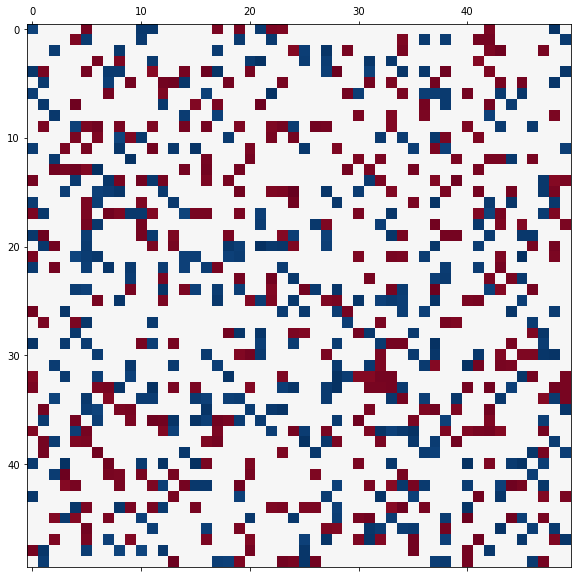

In [5]:
optimize(50, 50, 250, 500, 25, 10, freq=500, path="")
